In [4]:
import pandas as pd
import geopandas as geopd

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [5]:
max_seg_length = 4000


src_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/subwatersheds_{max_seg_length}.gpkg"
dst_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/subwatersheds_soil_{max_seg_length}.gpkg"
vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"

soil_path = "/home/iiro/Documents/DIWA/data/GTK/maaperä_sliced.gpkg"

watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

classes = {
    "stone": [195110, 195111, 195112, 195312],
    "coarse": [195310],
    "fine": [195410],
    "mixed": [195210],
    "clay": [195413],
    "ooze": [195511, 195618],
    "peat": [19551891, 19551892, 19551822]
    }

In [6]:
test_selection = 150

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    if i < test_selection:
        continue

    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])

    place_id = watershed.at[0, 'Paikka_Id']

    subwatersheds = geopd.read_file(src_path, layer=f"subwatersheds_{place_id}")

    minx = watershed.bounds.at[0, 'minx']
    miny = watershed.bounds.at[0, 'miny']
    maxx = watershed.bounds.at[0, 'maxx']
    maxy = watershed.bounds.at[0, 'maxy']

    soil = geopd.read_file(soil_path, bbox=(minx, miny, maxx, maxy))
    soil = soil.clip(watershed, keep_geom_type=True)
    for soil_class in classes:
        # Classifying into given classes
        soil.loc[soil["PINTAMAALAJI_KOODI"].isin(classes[soil_class]), "soil_class"] = soil_class

    for j, subwatershed in subwatersheds.iterrows():

        subwatershed = geopd.GeoDataFrame(
                dict(zip(list(subwatershed.index), list(subwatershed.values))),
                crs=subwatersheds.crs, geometry='geometry', index=[0])

        subwatershed_area = subwatershed.area.sum()
        
        subwatershed_soil = soil.clip(subwatershed, keep_geom_type=True)
        subwatershed_soil = subwatershed_soil.dissolve(by="soil_class", as_index=False)
        
        for soil_class in classes:
            soil_class_area = subwatershed_soil[subwatershed_soil["soil_class"] == soil_class].area.sum()
            subwatersheds.at[j, f"{soil_class}_portion"] = round(soil_class_area / subwatershed_area, 4)
        
    #soil = soil.dissolve(by="soil_class", as_index=False)

    subwatersheds.to_file(dst_path, layer=f"subwatersheds_{place_id}", driver="GPKG")
    if i == test_selection:
        break

  0%|          | 0/167 [00:00<?, ?it/s]

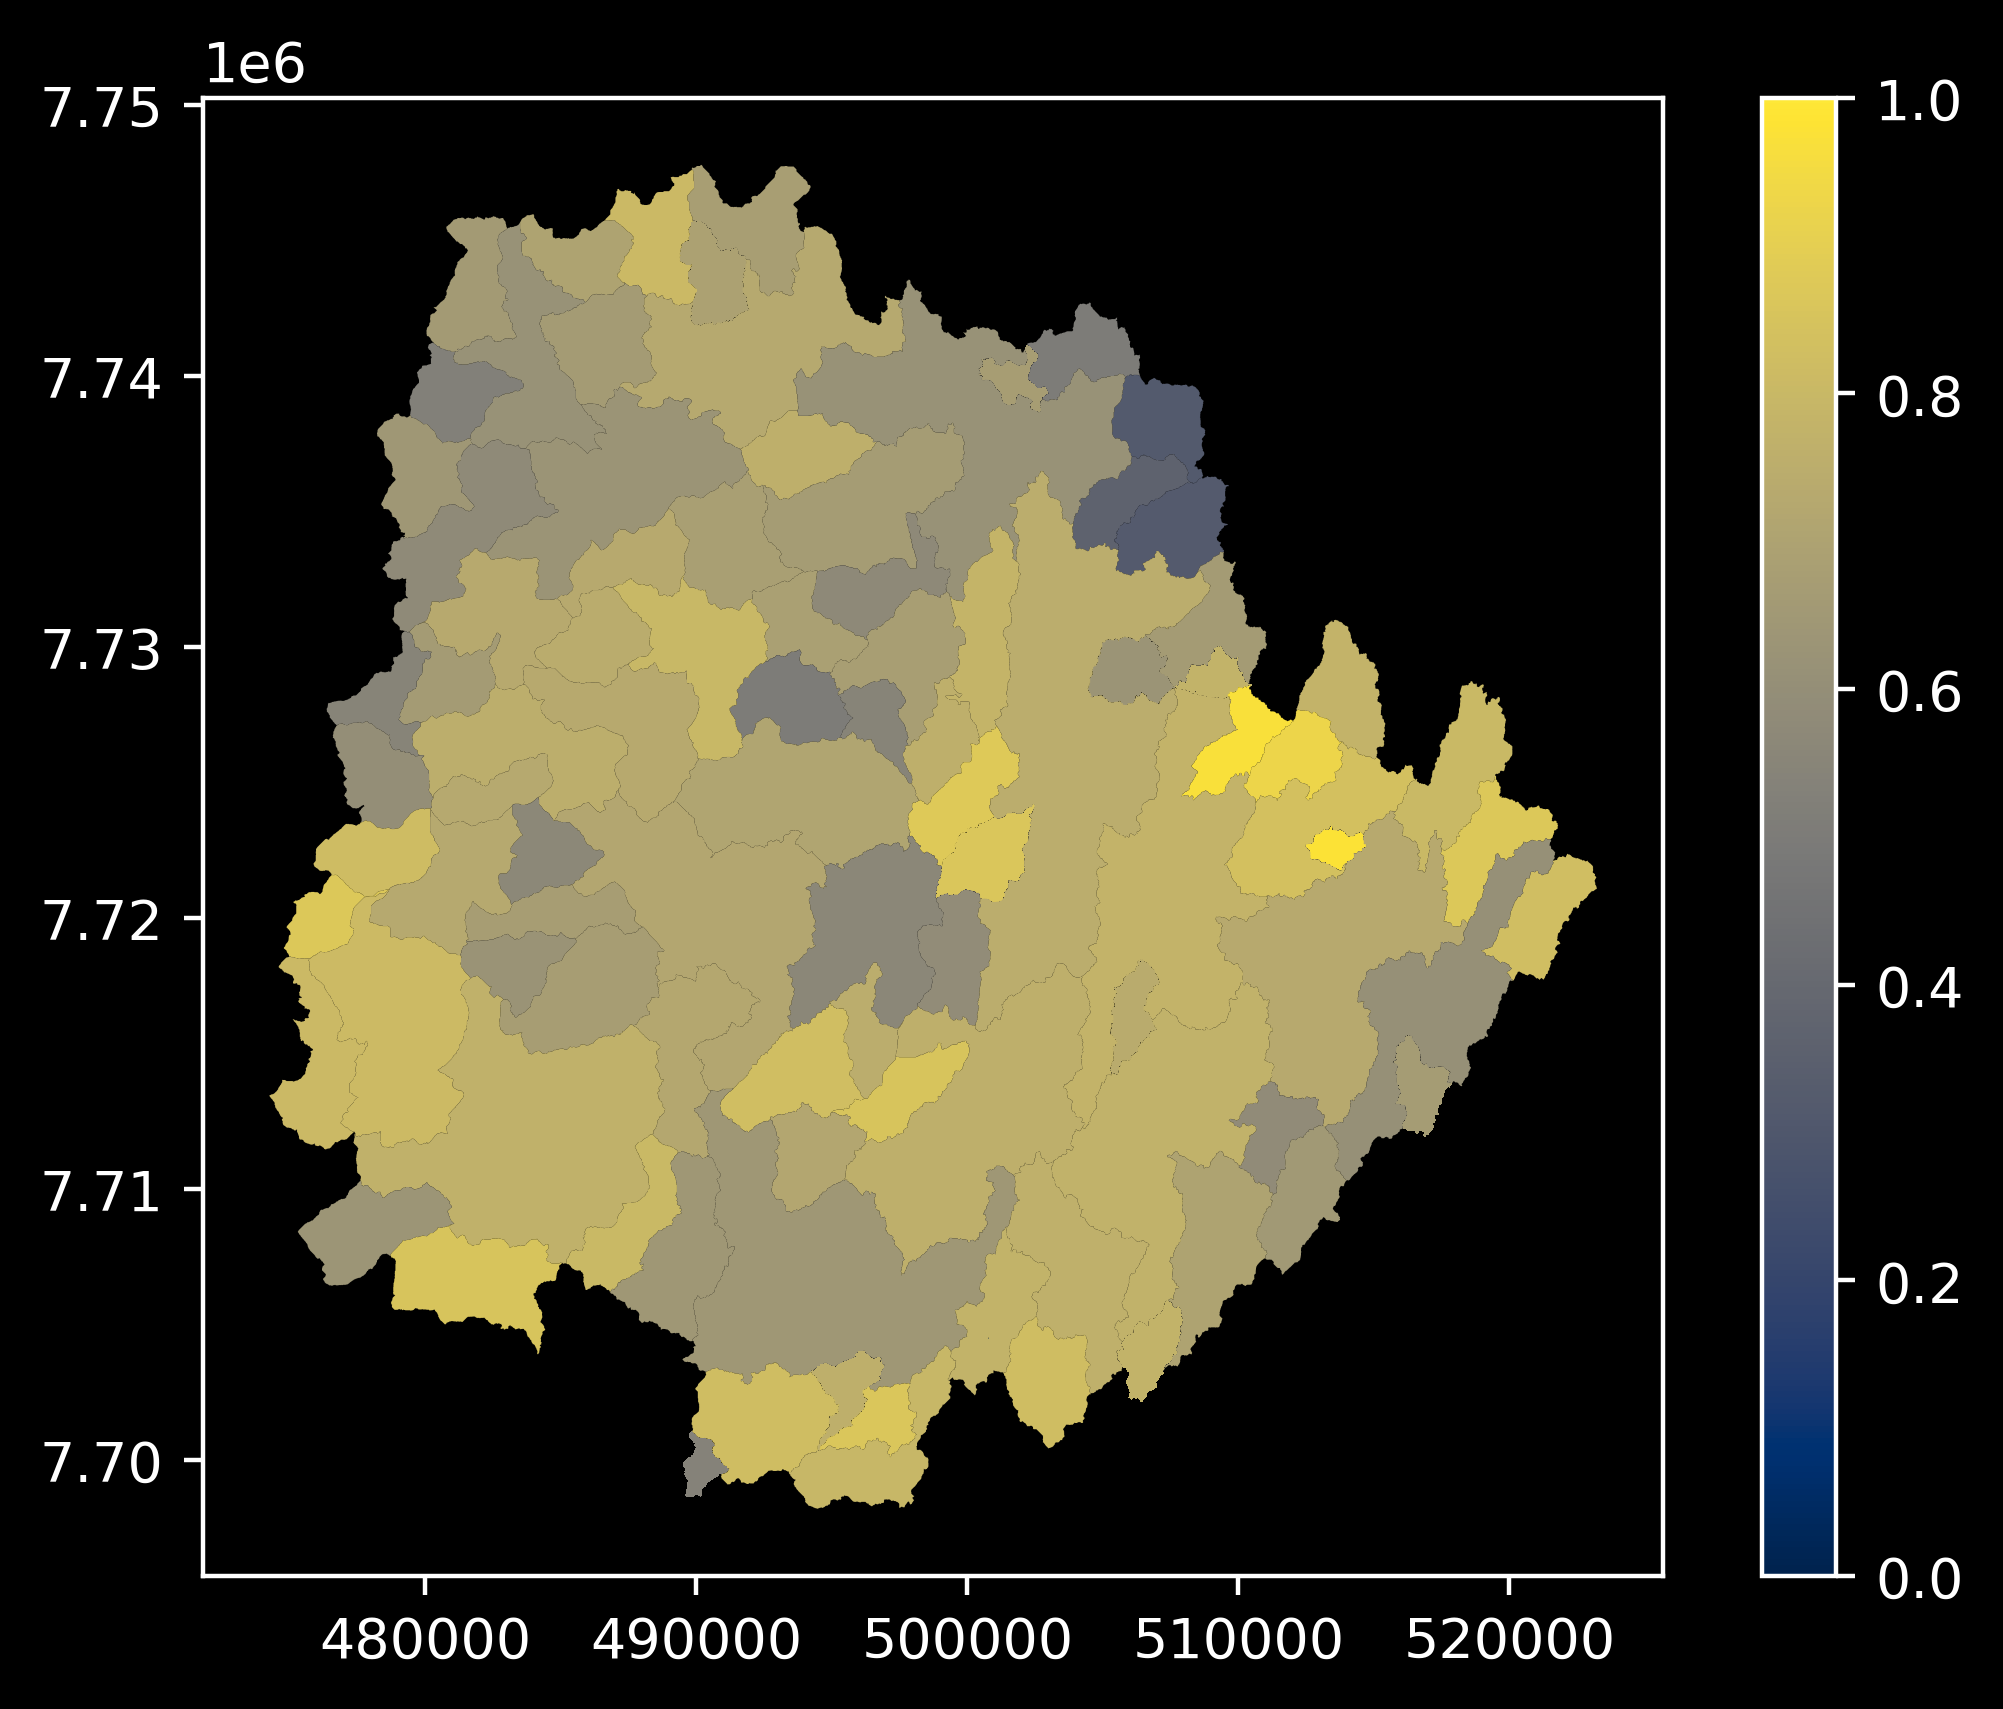

In [140]:
ax=subwatersheds.plot("mixed_portion", cmap="cividis", legend=True, vmax=1)

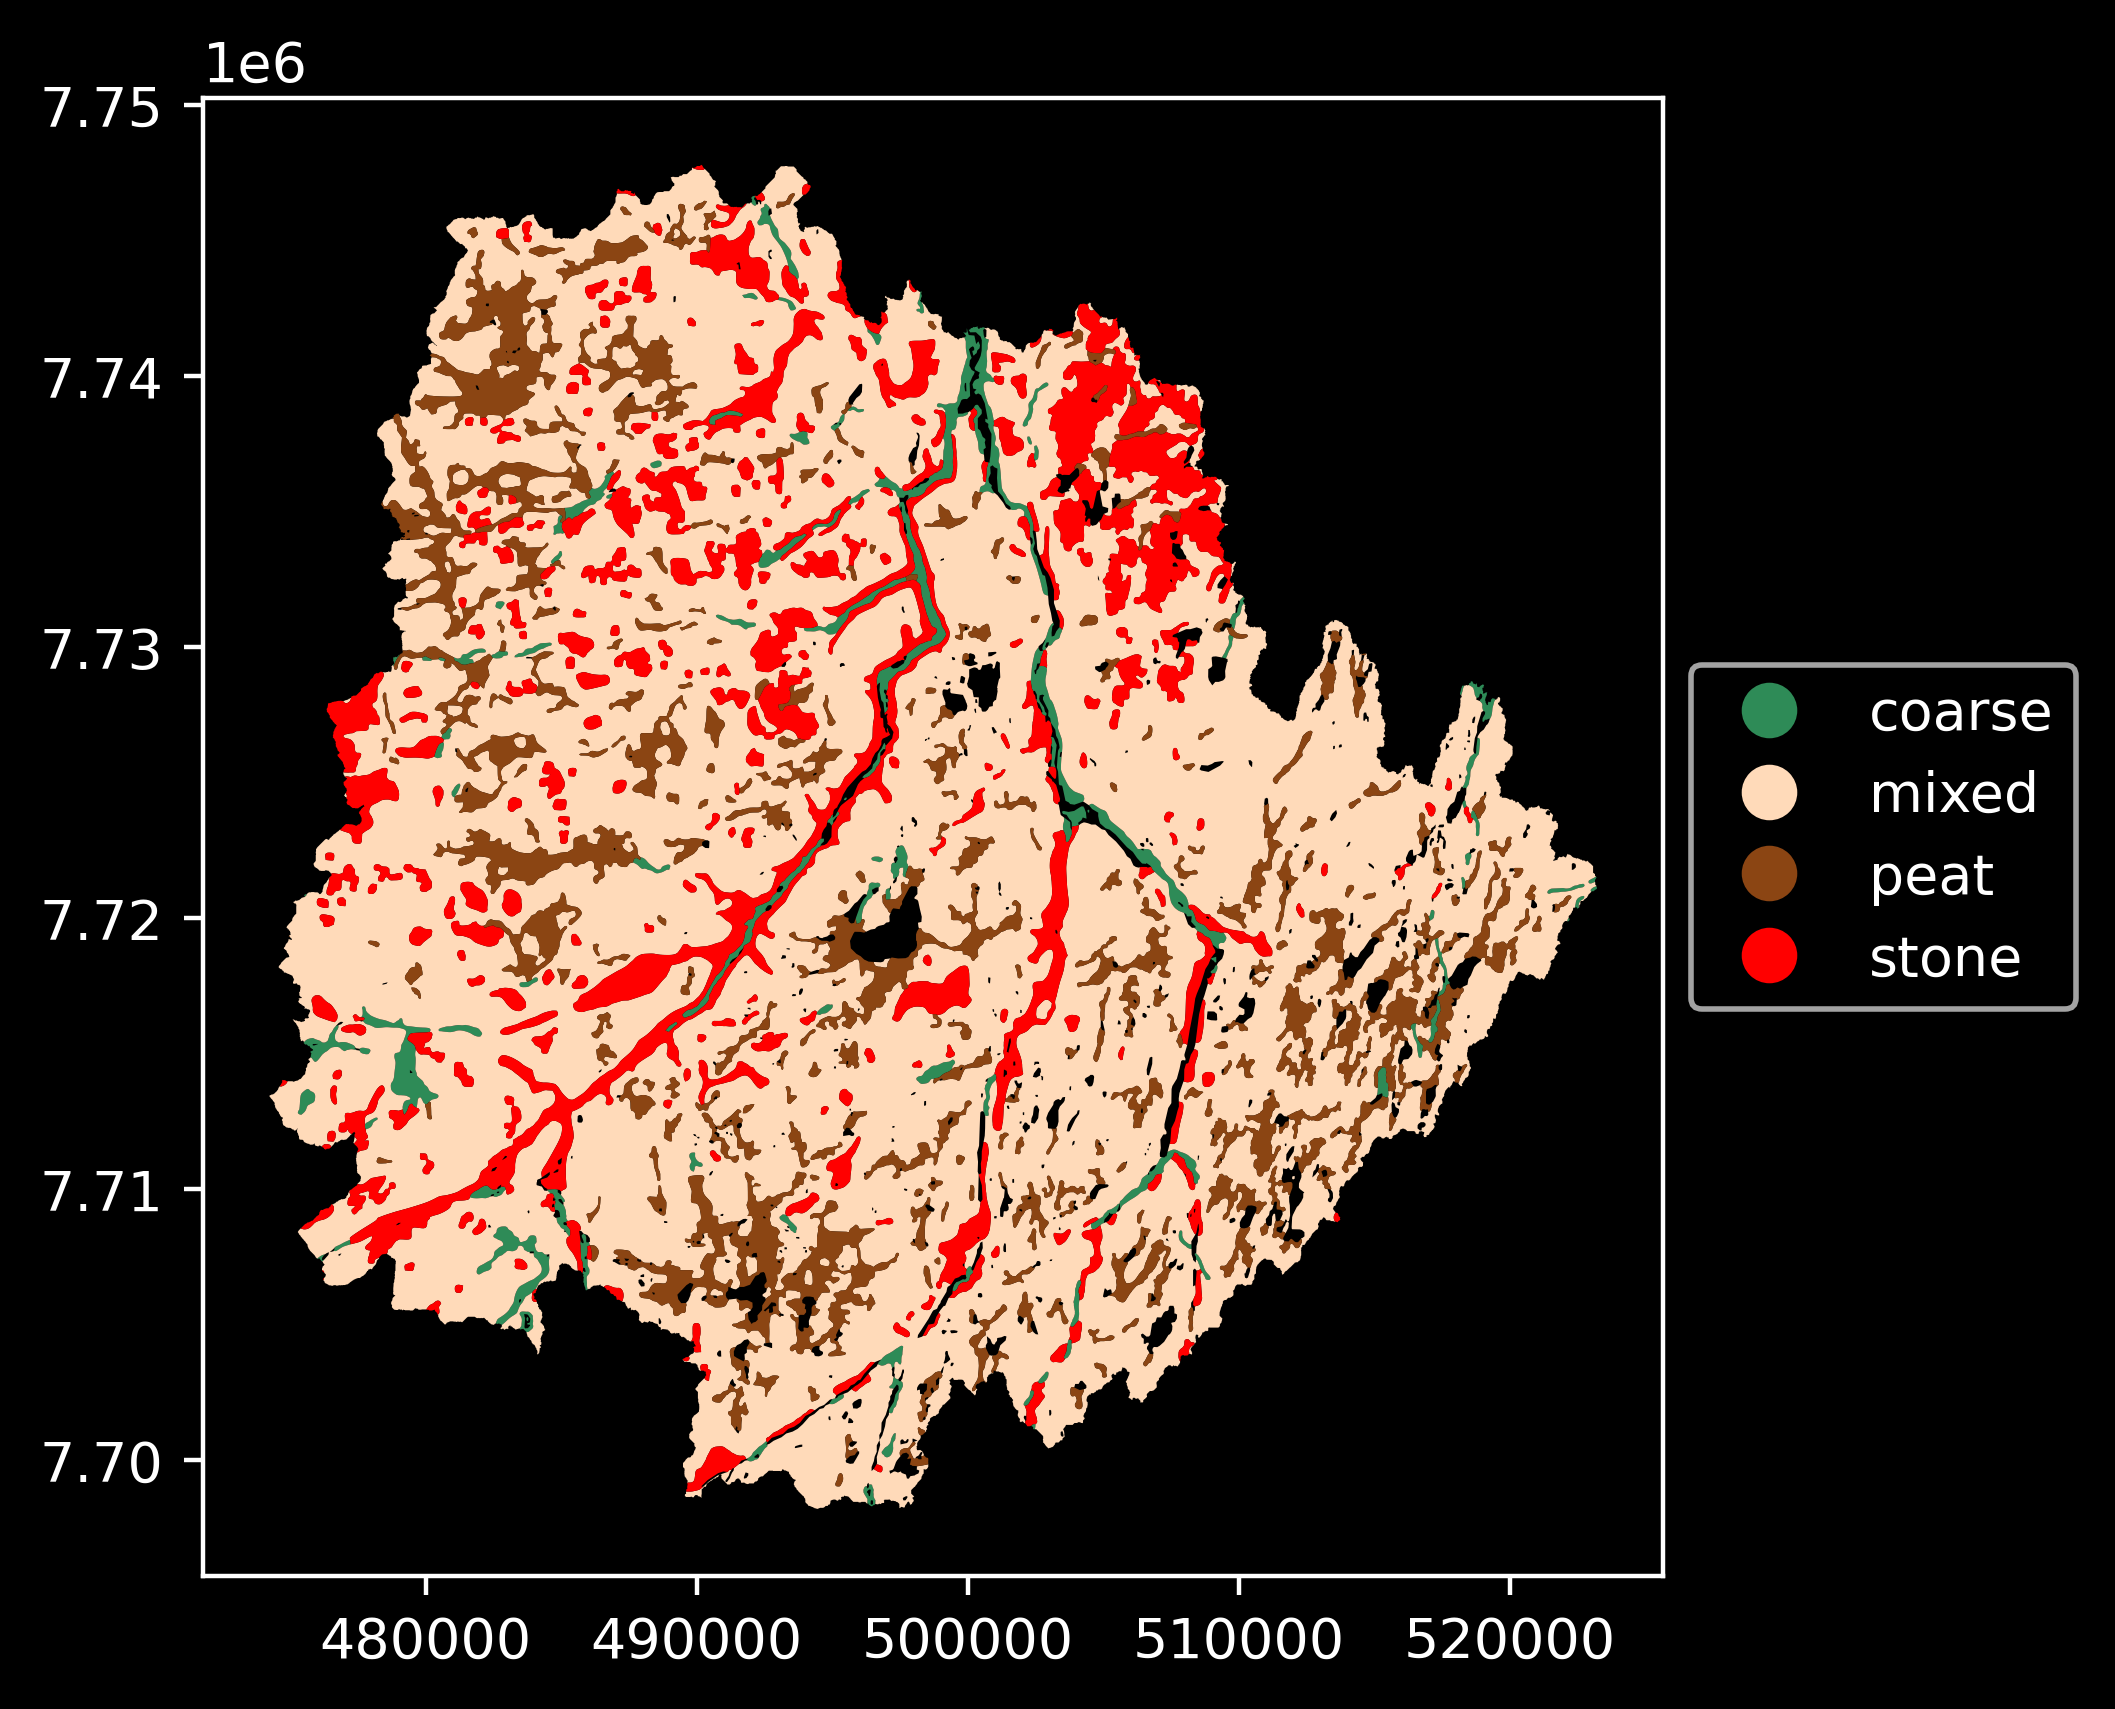

In [139]:
colors = {"clay":"lightskyblue", "coarse": "seagreen","fine": "greenyellow","mixed": "peachpuff","ooze": "violet","peat": "saddlebrown","stone": "red"}
# Choosing only the colors that are present
class_colors = [colors[soil_type] for soil_type in colors.keys() if soil_type in list(soil.soil_class)]

cmap = ListedColormap(class_colors)

ax=soil.plot("soil_class", cmap=cmap, legend=True, legend_kwds={"loc":'center left', "bbox_to_anchor":(1, 0.5)})
#ax = watershed.boundary.plot(ax=ax, color='white', linewidth=0.5)
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          #fancybox=False, labels=["clay", "coarse", "fine", "mixed", "ooze", "peat", "stone"])

In [102]:
subwatersheds

,Paikka_Id,main_basin_index,area_m2,id,pituus_m,next,pour,dam,in_connect,lake,...,peatland_portion_2018,water_portion_2018,geometry,stone_portion,coarse_portion,fine_portion,mixed_portion,clay_portion,ooze_portion,peat_portion
0,1117,15,4938400.0,48,3993.853186,140,False,False,0,False,...,0.033394,0.001500,"POLYGON ((267820 6758350, 267820 6758320, 2677...",0.0218,0.4703,0.0,0.0000,0.2997,0.0000,0.2068
1,1117,15,2351600.0,46,3185.227270,140,False,False,0,False,...,0.017848,0.000000,"POLYGON ((263400 6756500, 263400 6756490, 2633...",0.4230,0.0000,0.0,0.0000,0.5298,0.0000,0.0460
2,1117,15,28843300.0,140,3998.361541,142,False,False,2,False,...,0.012058,0.000668,"POLYGON ((266640 6760950, 266640 6760940, 2666...",0.0990,0.2304,0.0,0.0000,0.5989,0.0000,0.0707
3,1117,15,4960700.0,142,3348.295435,124,False,False,1,False,...,0.000235,0.000548,"POLYGON ((264710 6753050, 264710 6753040, 2646...",0.2455,0.0198,0.0,0.0000,0.5894,0.0000,0.1453
4,1117,15,5314800.0,30,7145.367263,24,False,False,0,False,...,0.070141,0.000146,"POLYGON ((258090 6752280, 258090 6752270, 2580...",0.2158,0.0000,0.0,0.0000,0.4193,0.0000,0.3635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1117,15,8677700.0,52,5975.484245,146,False,False,0,False,...,0.003385,0.000767,"POLYGON ((254000 6715230, 254000 6715190, 2539...",0.6325,0.0000,0.0,0.0000,0.3330,0.0000,0.0316
63,1117,15,32535400.0,146,2035.280030,74,False,False,3,False,...,0.000654,0.003212,"POLYGON ((256700 6718610, 256700 6718600, 2566...",0.6031,0.0000,0.0,0.0025,0.3695,0.0064,0.0061
64,1117,15,17599100.0,70,10.710392,71,False,True,2,False,...,0.000915,0.014861,"POLYGON ((245860 6717920, 245860 6717910, 2458...",0.5090,0.0125,0.0,0.0043,0.4349,0.0085,0.0000
65,1117,15,800.0,62,2610.791934,64,False,False,0,False,...,0.000000,0.000000,"POLYGON ((243540 6709370, 243540 6709360, 2435...",0.0000,0.0000,0.0,0.0000,1.0000,0.0000,0.0000


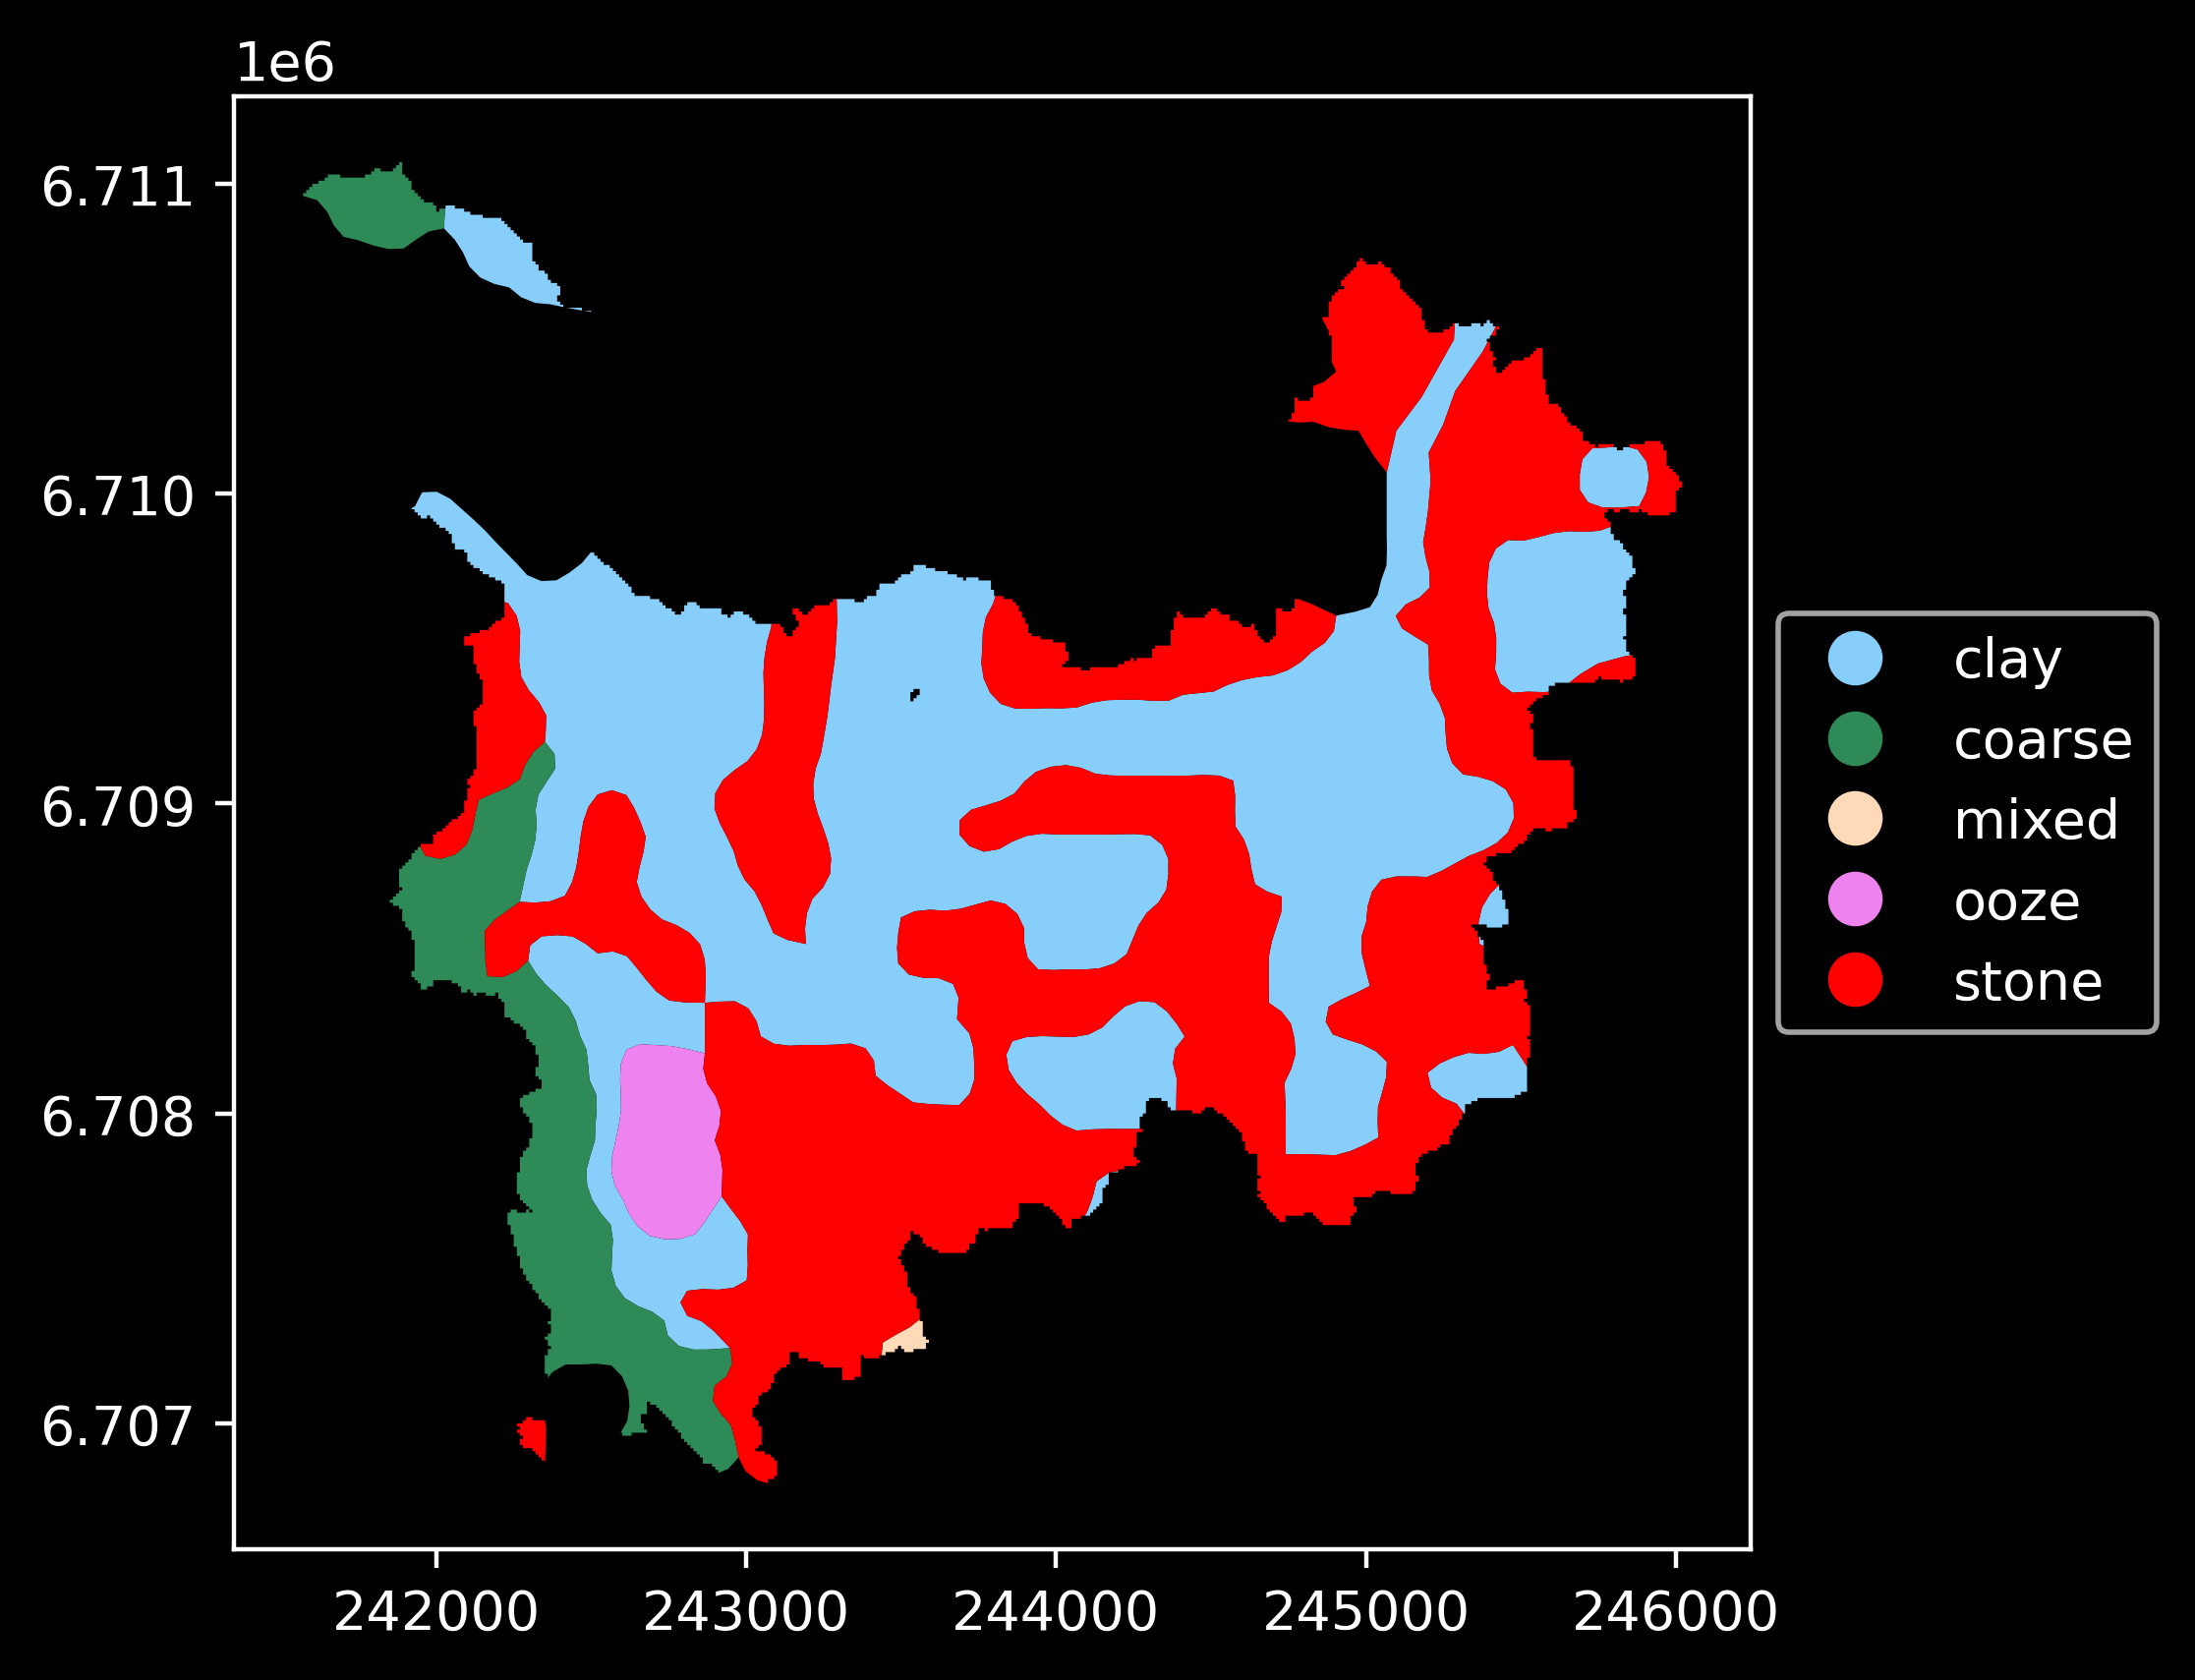

In [101]:
colors = {"clay":"lightskyblue", "coarse": "seagreen","fine": "greenyellow","mixed": "peachpuff","ooze": "violet","peat": "saddlebrown","stone": "red"}
# Choosing only the colors that are present
class_colors = [colors[soil_type] for soil_type in colors.keys() if soil_type in list(subwatershed_soil.soil_class)]

cmap = ListedColormap(class_colors)

ax=subwatershed_soil.plot("soil_class", cmap=cmap, legend=True, legend_kwds={"loc":'center left', "bbox_to_anchor":(1, 0.5)})
#ax = watershed.boundary.plot(ax=ax, color='white', linewidth=0.5)
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          #fancybox=False, labels=["clay", "coarse", "fine", "mixed", "ooze", "peat", "stone"])

In [99]:
subwatershed.area

0    4938400.0
dtype: float64